# CRISP DM – Modelamiento de reservas de seguros comerciales de autos con una metodología distinta a Chain ladder

por: Brian Felipe Sarmiento Valencia

## Introducción

El presente notebook de Jupyter con lenguaje python es la realización del proyecto de minería de datos para el cálculo de reservas de una compañía de seguros de automóviles comerciales, este notebook muestra la segunda, tercer y cuarta etapa de la metodología CRISP-DM, entendimiento de los datos, preparación de los datos y modelado.

## Entendimiento de los datos

In [1]:
#importe de librerías
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
import time

los datos sale de la siguiente papgina
https://www.casact.org/publications-research/research/research-resources/loss-reserving-data-pulled-naic-schedule-p

In [2]:
#Se crea data frame con la tabla que se desea procesar
df = pd.read_csv(r'C:\Users\USUARIO WINDOWS\OneDrive - Universidad Nacional de Colombia\Documentos\Maestria Actuaria\tercer_semestre\maquinas_actuaria\Proyecto\comauto_pos.csv') 
#df = pd.read_csv(r'C:\Users\USUARIO WINDOWS\OneDrive - Universidad Nacional de Colombia\Documentos\Maestria Actuaria\tercer_semestre\maquinas_actuaria\Proyecto\medmal_pos.csv') 


In [3]:
df #Visualización de la tabla

,GRCODE,GRNAME,AccidentYear,DevelopmentYear,DevelopmentLag,IncurLoss_C,CumPaidLoss_C,BulkLoss_C,EarnedPremDIR_C,EarnedPremCeded_C,EarnedPremNet_C,Single,PostedReserve97_C
0,266,Public Underwriters Grp,1988,1988,1,0,0,0,0,0,0,0,932
1,266,Public Underwriters Grp,1988,1989,2,0,0,0,0,0,0,0,932
2,266,Public Underwriters Grp,1988,1990,3,0,0,0,0,0,0,0,932
3,266,Public Underwriters Grp,1988,1991,4,0,0,0,0,0,0,0,932
4,266,Public Underwriters Grp,1988,1992,5,0,0,0,0,0,0,0,932
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15795,44598,College Liability Ins Co Ltd RRG,1997,2002,6,40,40,0,159,0,159,1,248
15796,44598,College Liability Ins Co Ltd RRG,1997,2003,7,40,40,0,159,0,159,1,248
15797,44598,College Liability Ins Co Ltd RRG,1997,2004,8,40,40,0,159,0,159,1,248
15798,44598,College Liability Ins Co Ltd RRG,1997,2005,9,29,29,0,159,0,159,1,248


El conjunto de datos contiene las siguientes varaibles

- GRCODE: El código de la compañía NAIC (National Association of Insurance Commissioners), que incluye tanto grupos de aseguradoras como aseguradoras individuales.
- GRNAME: El nombre de la compañía NAIC, que incluye tanto grupos de aseguradoras como aseguradoras individuales.
- AccidentYear: El año de ocurrencia de las reclamaciones. Este va desde 1988 hasta 1997.
- DevelopmentYear: El año de desarrollo de las reclamaciones. También varía de 1988 a 1997.
- DevelopmentLag: El rezago de desarrollo de las reclamaciones, calculado como (AccidentYear - 1987) + (DevelopmentYear - 1987) - 1.
- IncurLoss_: Pérdidas incurridas y gastos asignados reportados al final del año.
- CumPaidLoss_: Pérdidas pagadas acumuladas y gastos asignados al final del año.
- BulkLoss_: Reservas masivas (Bulk) e IBNR (Incurred But Not Reported) sobre pérdidas netas y gastos de defensa y costos de contención informados al final del año.
- PostedReserve97_: Reservas publicadas en el año 1997, tomadas del "Underwriting and Investment Exhibit – Part 2A," incluyendo pérdidas netas no pagadas y gastos de ajuste no pagados.
- EarnedPremDIR_: Primas devengadas en el año de ocurrencia, tanto directas como asumidas.
- EarnedPremCeded_: Primas devengadas en el año de ocurrencia, cedidas a reaseguradores.
- EarnedPremNet_: Primas devengadas en el año de ocurrencia, netas (directas menos cedidas).
- Single: Un indicador que toma el valor 1 si se trata de una entidad única y 0 si se trata de una aseguradora del grupo.

El dataframe o tabla de datos contiene 15800 registros y 13 columnas

In [4]:
df.shape

(15800, 13)

### Interpretación de una observación

In [5]:
df[df["GRCODE"] == 44598].iloc[0] #Primera observación de la tabla

GRCODE                                          44598
GRNAME               College Liability Ins Co Ltd RRG
AccidentYear                                     1988
DevelopmentYear                                  1988
DevelopmentLag                                      1
IncurLoss_C                                        74
CumPaidLoss_C                                      15
BulkLoss_C                                         39
EarnedPremDIR_C                                   117
EarnedPremCeded_C                                   0
EarnedPremNet_C                                   117
Single                                              1
PostedReserve97_C                                 248
Name: 15700, dtype: object

De lo anterior registro se puede comentar:

- AccidentYear y DevelopmentYear indican que esta observación se refiere a reclamaciones relacionadas con el año de ocurrencia 1988 y se está evaluando en el mismo año, lo que significa que no se ha producido ningún desarrollo adicional desde la ocurrencia de las reclamaciones en 1988.
- DevelopmentLag tiene un valor de 1, lo que significa que estas reclamaciones se refieren al primer año de desarrollo después de la ocurrencia. Esto puede interpretarse como que las reclamaciones se están evaluando un año después de su ocurrencia.
- IncurLoss_C indica que la entidad ha incurrido en pérdidas y gastos asignados por un total de 74 unidades monetarias en el año de ocurrencia 1988.
- CumPaidLoss_C muestra que las pérdidas pagadas acumuladas y los gastos asignados hasta el año de desarrollo 1988 ascienden a 15 unidades monetarias.
- BulkLoss_C representa las reservas masivas (Bulk) e IBNR sobre pérdidas netas y gastos de defensa y costos de contención informados al final del año 1988, con un valor de 39 unidades monetarias.
- EarnedPremDIR_C, EarnedPremCeded_C, y EarnedPremNet_C indican las primas devengadas en el año de ocurrencia 1988, tanto directas como cedidas, y la cantidad neta (después de deducir las cedidas). En este caso, las primas netas (EarnedPremNet_C) totalizan 117 unidades monetarias.
- Single es un indicador que toma el valor 1, lo que sugiere que esta entidad es una entidad única, no una parte de un grupo de aseguradoras.
- PostedReserve97_C muestra las reservas publicadas en el año 1997 para esta entidad, que incluyen pérdidas netas no pagadas y gastos de ajuste no pagados por un total de 248 unidades monetarias.

### Resumen numérico

In [6]:
df.info() #Información genérica de la tabla

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15800 entries, 0 to 15799
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   GRCODE             15800 non-null  int64 
 1   GRNAME             15800 non-null  object
 2   AccidentYear       15800 non-null  int64 
 3   DevelopmentYear    15800 non-null  int64 
 4   DevelopmentLag     15800 non-null  int64 
 5   IncurLoss_C        15800 non-null  int64 
 6   CumPaidLoss_C      15800 non-null  int64 
 7   BulkLoss_C         15800 non-null  int64 
 8   EarnedPremDIR_C    15800 non-null  int64 
 9   EarnedPremCeded_C  15800 non-null  int64 
 10  EarnedPremNet_C    15800 non-null  int64 
 11  Single             15800 non-null  int64 
 12  PostedReserve97_C  15800 non-null  int64 
dtypes: int64(12), object(1)
memory usage: 1.6+ MB


De la salida anterior se tiene que la mayoría de las variables son numéricas y solo una es de tipo string o cadena

#### Estadística descriptiva

In [7]:
df.describe()[['AccidentYear', 'DevelopmentYear', 'DevelopmentLag',
       'IncurLoss_C', 'CumPaidLoss_C', 'BulkLoss_C', 'EarnedPremDIR_C',
       'EarnedPremCeded_C', 'EarnedPremNet_C', 'Single', 'PostedReserve97_C']] #estadísticas de la tabla

,AccidentYear,DevelopmentYear,DevelopmentLag,IncurLoss_C,CumPaidLoss_C,BulkLoss_C,EarnedPremDIR_C,EarnedPremCeded_C,EarnedPremNet_C,Single,PostedReserve97_C
count,15800.000000,15800.000000,15800.000000,15800.000000,15800.000000,15800.000000,15800.000000,15800.000000,15800.000000,15800.000000,15800.000000
mean,1992.500000,1997.000000,5.500000,5155.741899,4190.973481,357.358101,8985.444937,1508.888608,7476.555696,0.721519,10815.107595
std,2.872372,4.062148,2.872372,20372.413914,17662.754124,2946.305828,33696.348166,5405.614677,31555.933962,0.448266,36441.236762
min,1988.000000,1988.000000,1.000000,-253.000000,-253.000000,-1395.000000,-445.000000,-3329.000000,-128.000000,0.000000,0.000000
25%,1990.000000,1994.000000,3.000000,5.000000,2.750000,0.000000,42.750000,0.000000,19.750000,0.000000,121.000000
50%,1992.500000,1997.000000,5.500000,315.000000,229.000000,0.000000,732.000000,73.000000,549.500000,1.000000,938.000000
75%,1995.000000,2000.000000,8.000000,1965.000000,1535.250000,26.000000,3991.500000,656.250000,2810.500000,1.000000,4711.000000
max,1997.000000,2006.000000,10.000000,256434.000000,244280.000000,105923.000000,412331.000000,60233.000000,406609.000000,1.000000,360657.000000


De la salida de sobre estadística descriptivas de las variables numéricas se destaca que todas las variables están completas, hay valores en negativo para las variables IncurLoss_C, CumPaidLoss_C, BulkLoss_C, EarnedPremDIR_C, EarnedPremCeded_C y EarnedPremNet_C lo cual puede ser indicio de que hay problemas con los datos, las variable más asimétricas son nuevamente IncurLoss_C, CumPaidLoss_C, BulkLoss_C, EarnedPremDIR_C, EarnedPremCeded_C, EarnedPremNet_C, además los valores máximos de estas variables indican que hay una asimetría hacia la derecha, y como la desviación estándar indica que hay valores muy alejados de la media, indicios de posibles valores atípicos.

In [8]:
df.describe(include=['object']) #estadísticas de la variable categórica 

,GRNAME
count,15800
unique,157
top,Farmers Union Mut Ins Co
freq,200


La anterior salida muestra que la variable categórica tiene 157 aseguradoras diferentes donde la que más se repite es Farmers Union Mut Ins Co, sin embargo la cantidad de aseguradoras por código son 158 donde no hay ninguna que se repita más que otra.

In [9]:
df["GRCODE"].value_counts() #Conteo de los códigos de las aseguradoras

266      100
26905    100
23574    100
23663    100
25275    100
        ... 
10894    100
11037    100
11118    100
11126    100
44598    100
Name: GRCODE, Length: 158, dtype: int64

### Resumen Gráfico

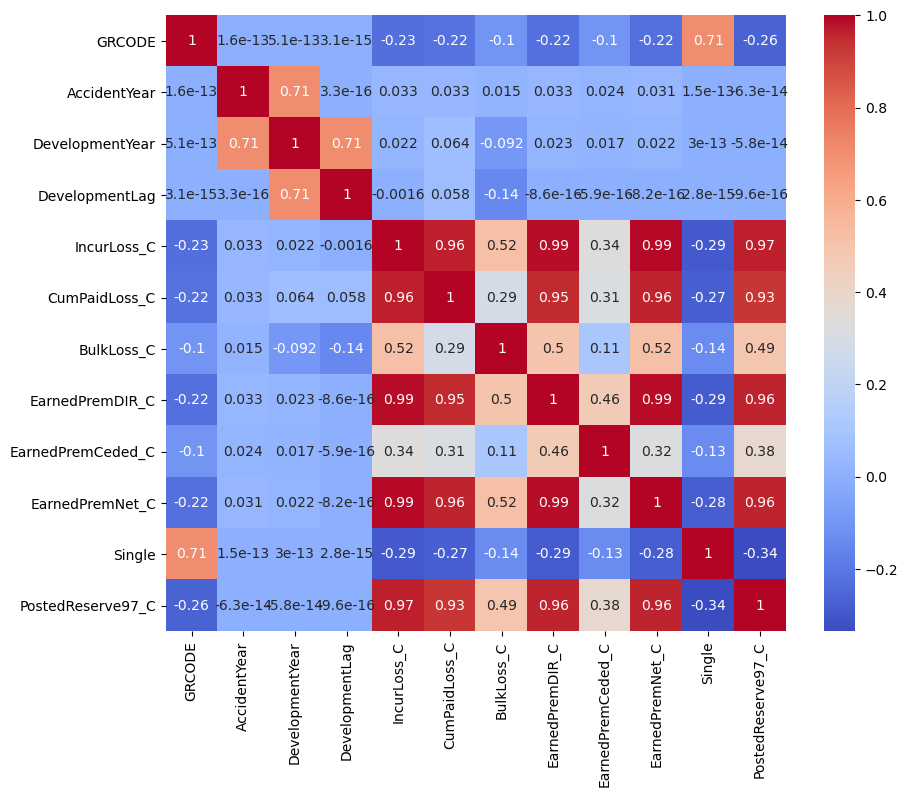

In [11]:
#Cálculo de matriz de correlaciones
corr = df.corr()
plt.figure(figsize=(10, 8))
sb.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

El anterior gráfico de correlaciones indica que la mayoría de la variable estan incorrelacionadas unas con otras, a excepción de las parejas (EarnedPremNet_C, PostedReserve97_C), (EarnedPremDIR_C, PostedReserve97_C), (EarnedPremDIR_C, EarnedPremNet_C), entre otras

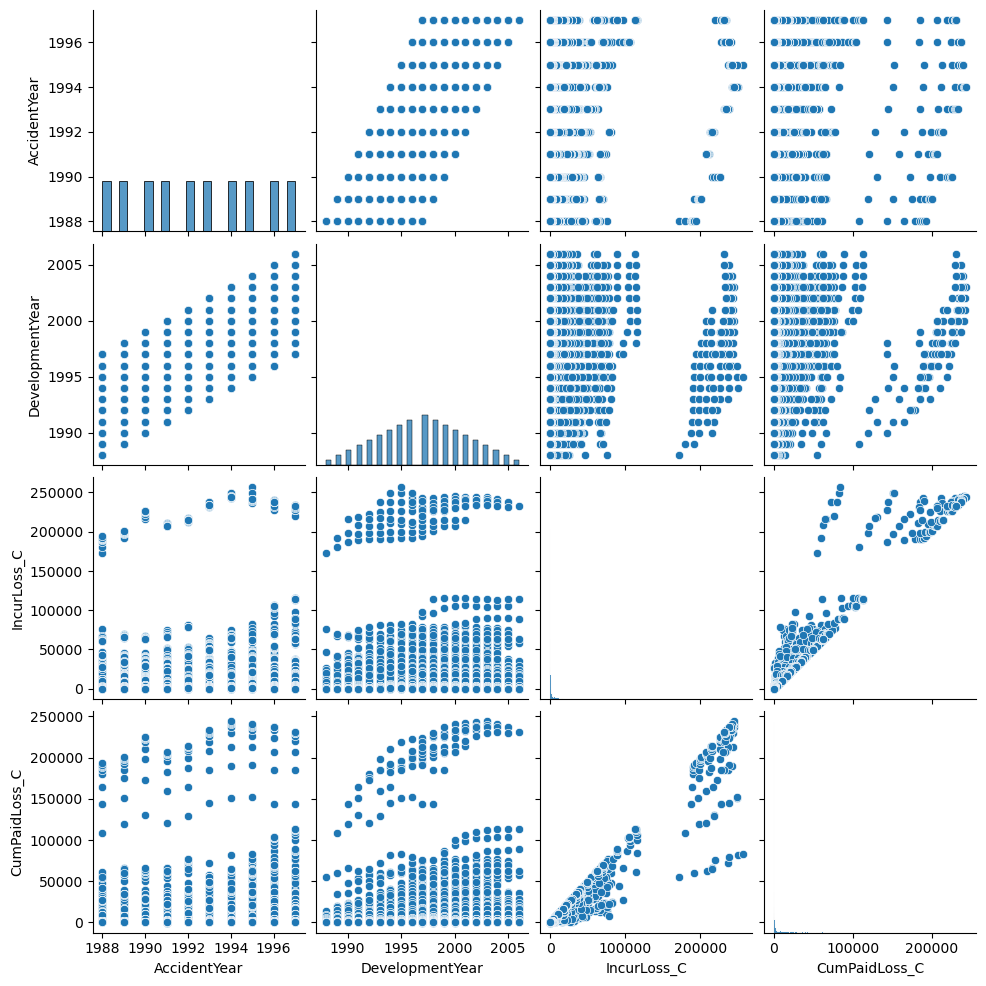

In [12]:
# Gráfico de dispersión
sb.pairplot(df[['AccidentYear', 'DevelopmentYear', 'IncurLoss_C', 'CumPaidLoss_C']])
plt.show()

De la gráfica anterior donde se grafican las columnas AccidentYear, DevelopmentYear, IncurLoss_C, CumPaidLoss_C las cuales son las más importantes para el cálculo de reservas se tiene como comentario más importante que el IncurLoss_C parece tener una relación con CumPaidLoss_C, por otro lado no se evidencia una relación aparente en las demás columnas.

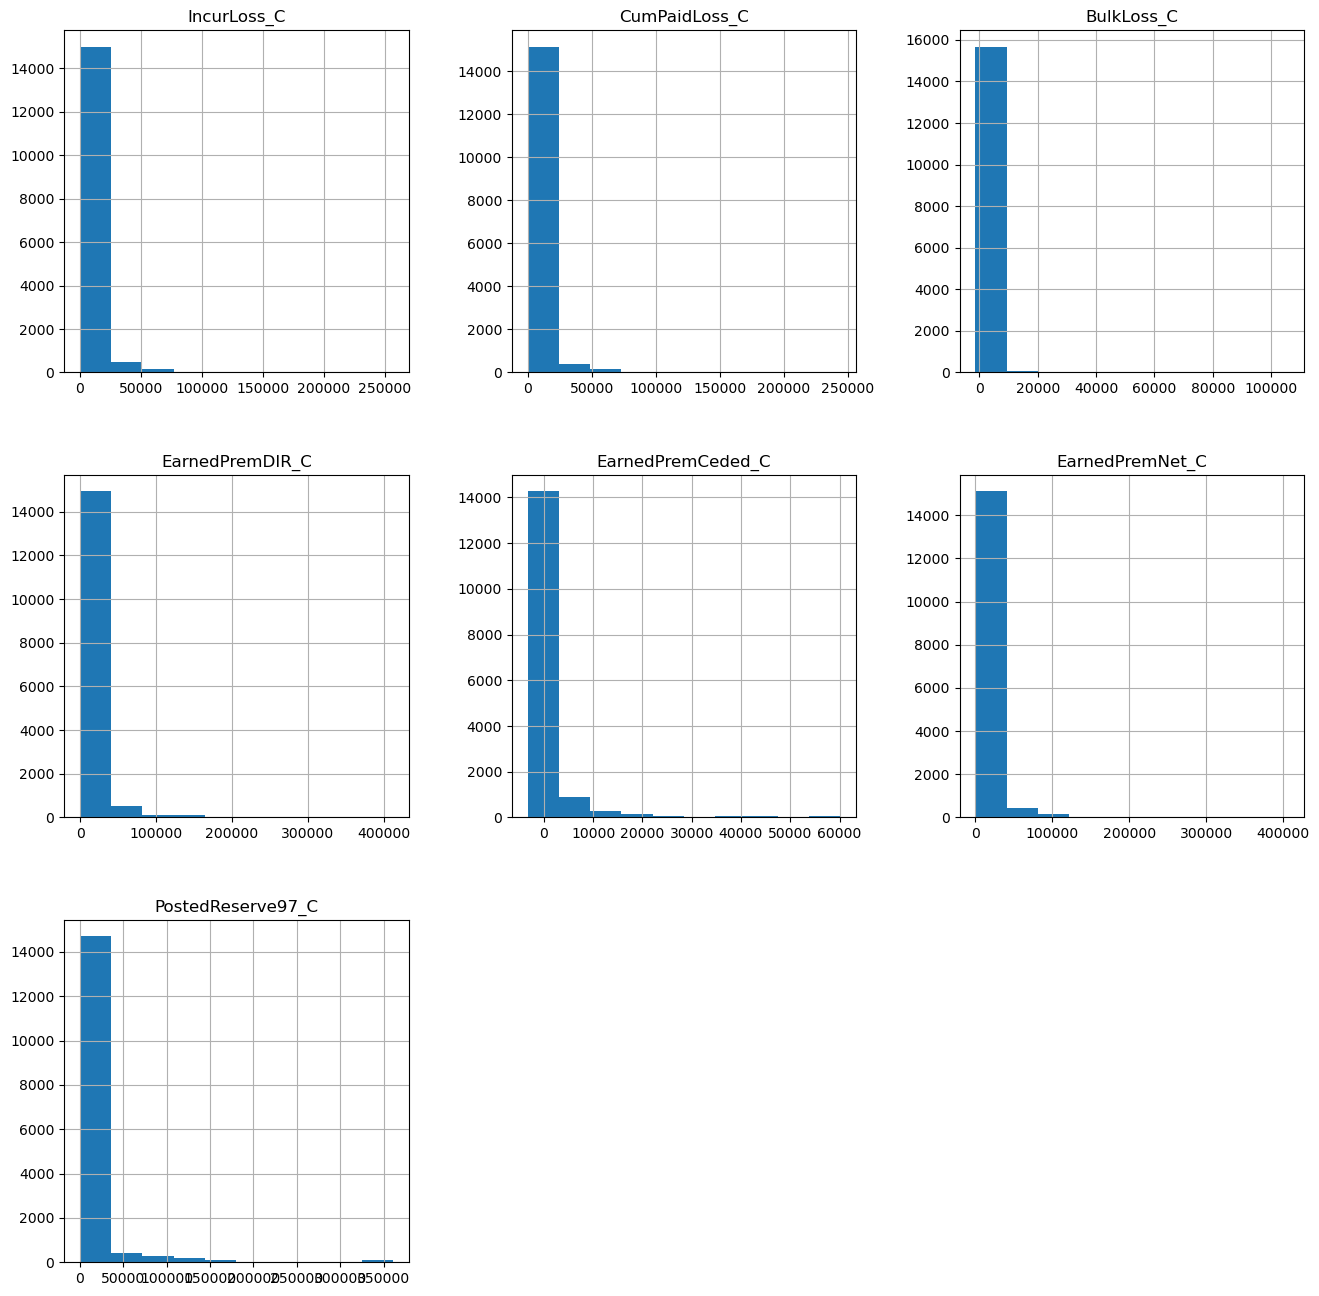

In [13]:
#Histogramas
#mnist.data.iloc[:,lista_columnas].hist(figsize=(16,16)) 
df[['IncurLoss_C', 'CumPaidLoss_C', 'BulkLoss_C', 'EarnedPremDIR_C','EarnedPremCeded_C', 'EarnedPremNet_C', 'PostedReserve97_C']].hist(figsize=(16,16)) 
plt.show()

Los histogramas anteriores reafirman los comentarios de la estadística descriptiva, hay una asimetría a la derecha y la mayoría de los datos se concentran en los valores más pequeños

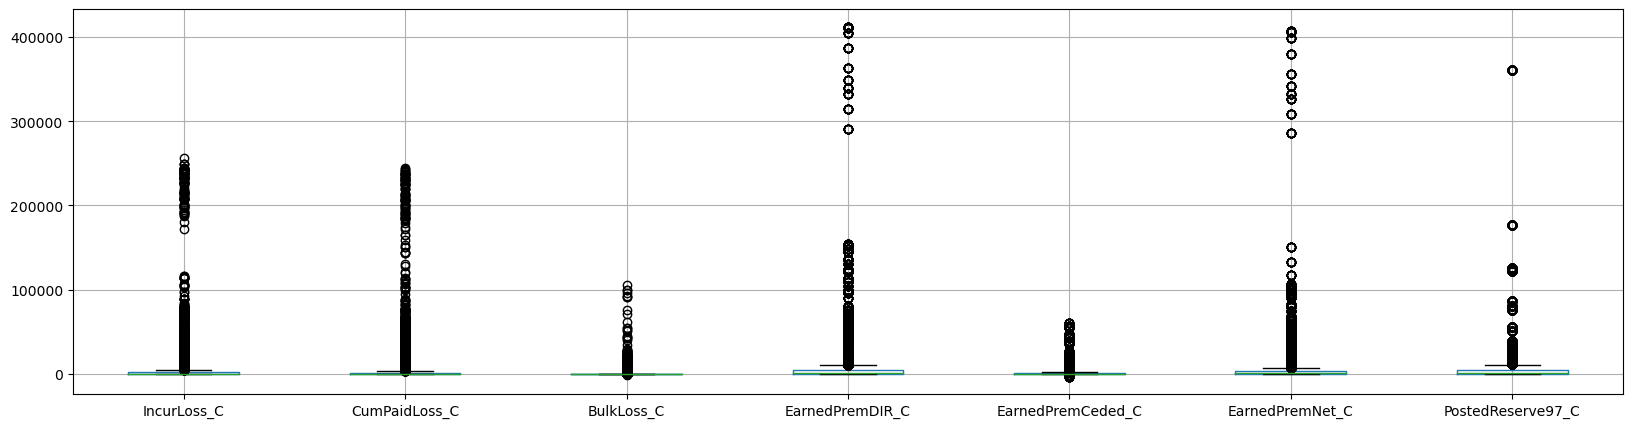

In [14]:
#Box-plot
df[['IncurLoss_C', 'CumPaidLoss_C', 'BulkLoss_C', 'EarnedPremDIR_C','EarnedPremCeded_C', 'EarnedPremNet_C', 'PostedReserve97_C']].boxplot(figsize=(20,5))
plt.show()

Las Gráficas de Box-plot anteriores de las variable numéricas indican que hay una asimetría muy marcada y presencia de valores atípicos, sin embargo la información desde el negocio indica que eso "valores atípicos" pueden ser reales y tienen un sentido en la compañía.

### Preguntas importantes sobre los datos y formular hipotesis

#### ¿Qué tan rentables son las compañías?

Realizaremos una comparación entre el monto total de las primas emitidas y los costos incurridos durante un período de 10 años hasta 1997. Esto incluye tanto los pagos realizados por siniestros ocurridos como las reservas para siniestros reportados que aún no se han pagado.

Esta aproximación es necesaria porque si solo se consideraran los pagos, se estaría exagerando las ganancias. Para hacer el análisis más realista, asumiremos que nos encontramos en el año 1997. Esto tiene implicaciones importantes: en el caso del año 1988, la compañía ya ha pagado la mayoría de los siniestros reportados, por lo que la reserva para siniestros reportados es muy baja. Sin embargo, para el año 1997 y años cercanos, la proporción de siniestros pagados es significativamente menor en comparación con la reserva para siniestros reportados. Esto significa que gran parte de los registros se basan en estimaciones.

En la gráfica, se presentan las primas emitidas durante esos 10 años en orden descendente, y se contrastan con los pagos realizados más las reservas para siniestros reportados. Se observa que algunas compañías muestran costos incurridos que superan el monto de las primas recibidas. Esto sugiere que en ese ramo de negocio específico, la rentabilidad es cuestionable, ya que los costos superan los ingresos generados por las primas emitidas. La aseguradora más grande es State Farm Mut Grp

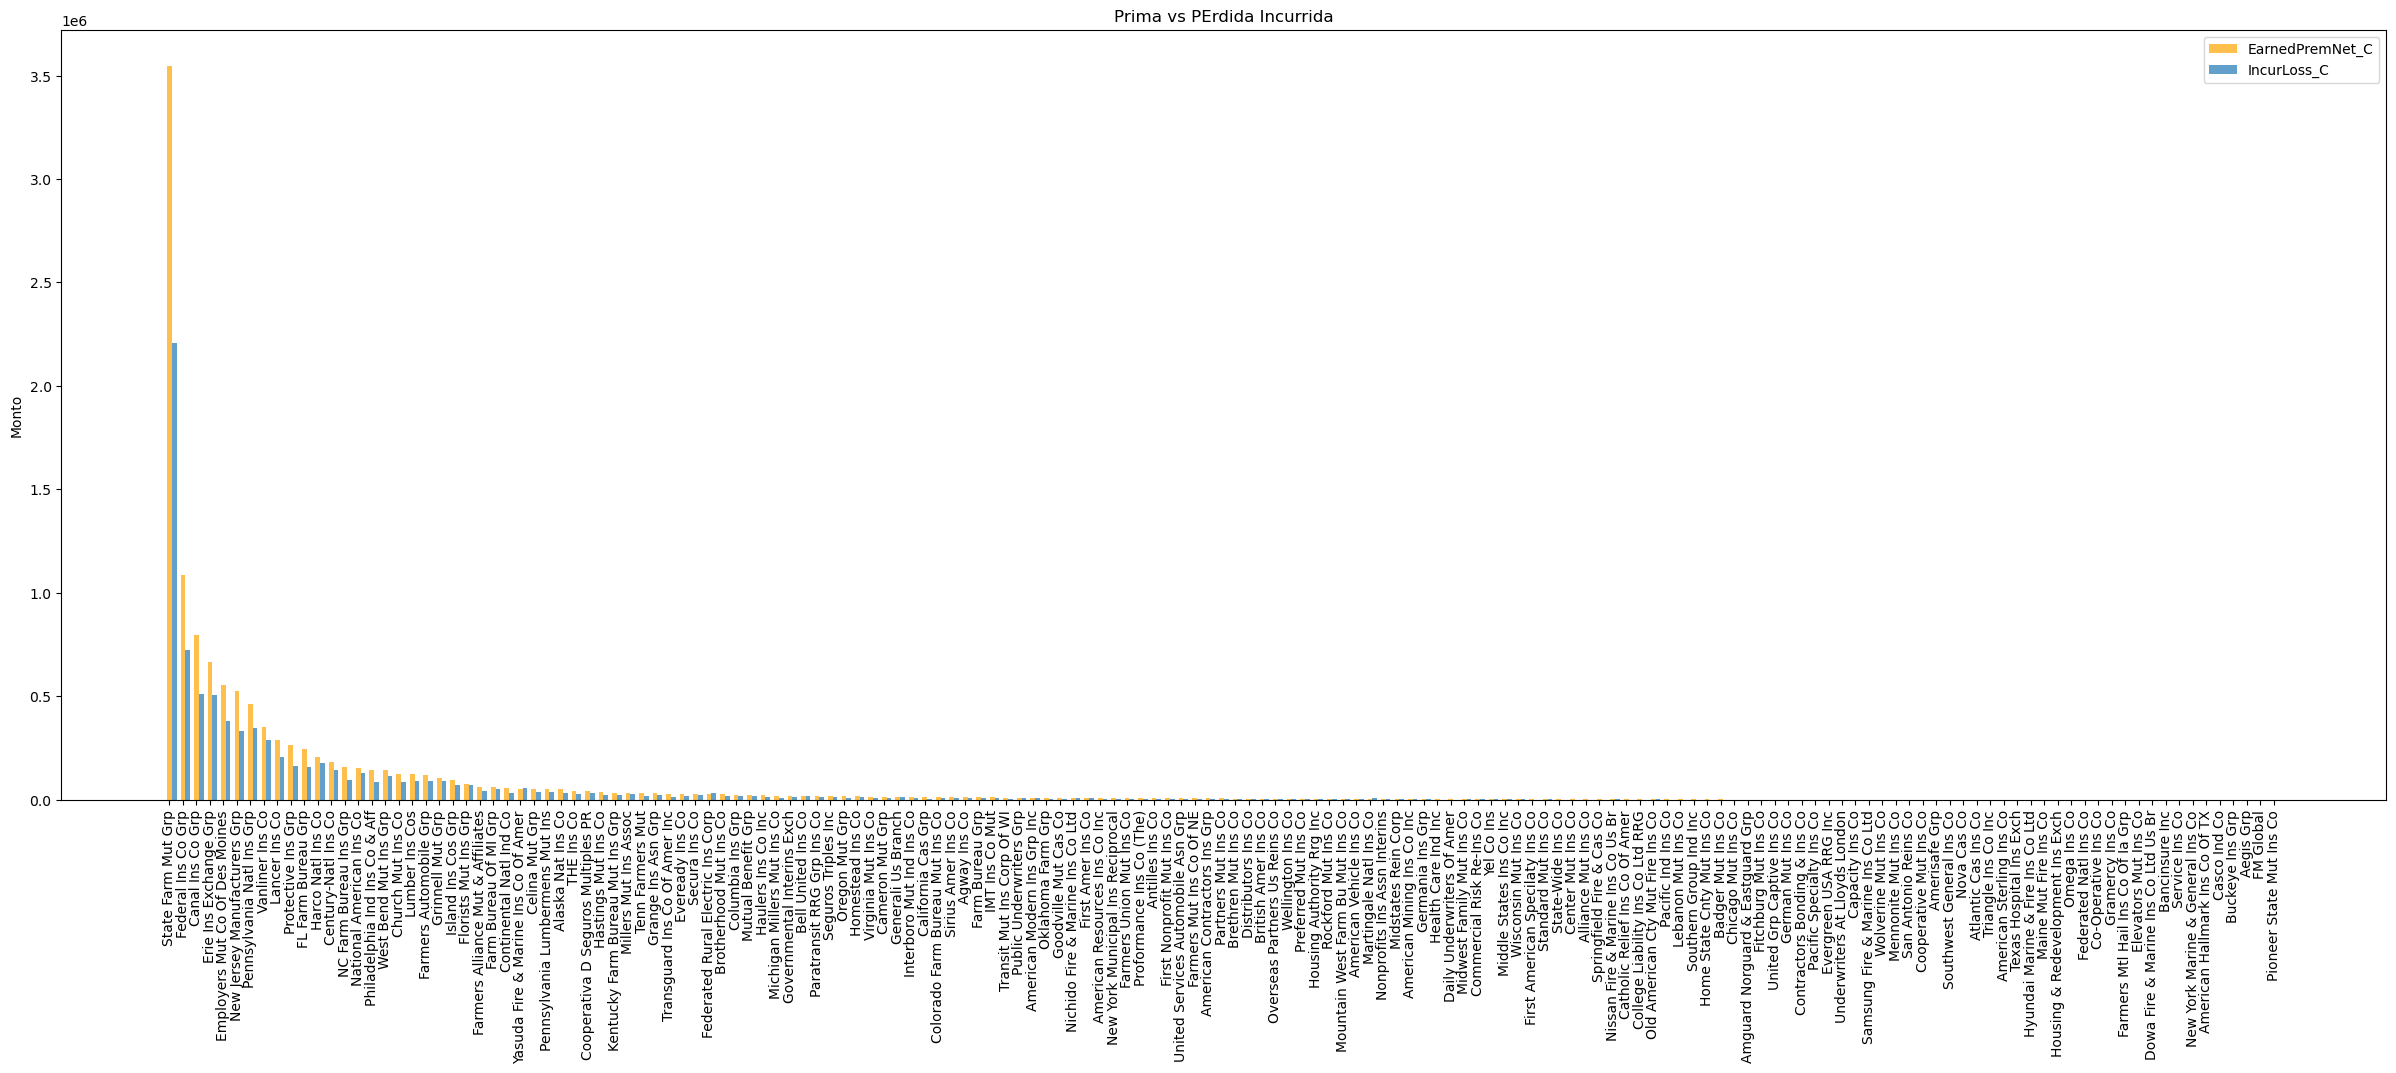

In [33]:
df_triangulo = df[(df['DevelopmentYear']==1997)].copy()
df_triangulo = df_triangulo[['GRNAME', 'AccidentYear', 'DevelopmentYear', 'IncurLoss_C','CumPaidLoss_C', 'BulkLoss_C', 'EarnedPremNet_C']].copy()
grouped_data = df_triangulo.groupby('GRNAME').agg({'IncurLoss_C': 'sum', 'EarnedPremNet_C': 'sum'}).reset_index()

# Ordenar el DataFrame por 'EarnedPremNet_C'
grouped_data_sorted = grouped_data.sort_values(by='EarnedPremNet_C', ascending=False)

# Crear una figura
plt.figure(figsize=(30, 10))

# Obtener la cantidad de grupos (GRNAME)
num_groups = len(grouped_data_sorted['GRNAME'])

# Establecer el ancho de las barras
bar_width = 0.35

# Coordenadas x para las barras de 'EarnedPremNet_C'
index_earned = range(num_groups)

# Coordenadas x para las barras de 'IncurLoss_C' (desplazadas hacia la derecha)
index_incur = [i + bar_width for i in index_earned]

# Crear las barras para 'EarnedPremNet_C'
plt.bar(index_earned, grouped_data_sorted['EarnedPremNet_C'], bar_width, label='EarnedPremNet_C', alpha=0.7, color='orange')

# Crear las barras para 'IncurLoss_C'
plt.bar(index_incur, grouped_data_sorted['IncurLoss_C'], bar_width, label='IncurLoss_C', alpha=0.7)

# Configurar etiquetas de ejes y título
plt.ylabel('Monto')
plt.title('Prima vs PErdida Incurrida')

# Configurar las etiquetas en el eje x de forma vertical
plt.xticks(index_earned, grouped_data_sorted['GRNAME'], rotation='vertical')

# Mostrar la leyenda
plt.legend()
# Mostrar el gráfico de barras
plt.show()


#### ¿Qué tanto acapara la compañía más grande State Farm Mut Grp el mercado?

Como se vio anteriormente la compañía State Farm Mut Grp es la más grande, la proxima gráfica muestra que esta compañía acapara el 30% del mercado total

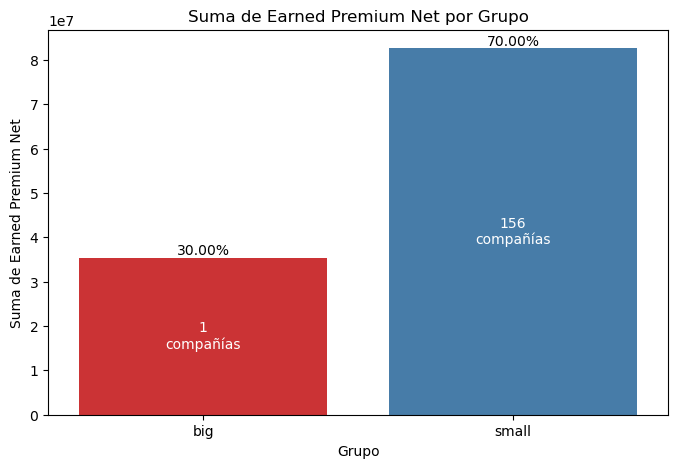

In [36]:
grupo_mapping = {
    'State Farm Mut Grp': 'big'}

primas = df.copy()

primas['grupo'] = primas['GRNAME'].map(grupo_mapping).fillna('small')

# Calcular la suma de 'EarnedPremNet_C' y el número de compañías diferentes por 'grupo'
grouped_data = primas.groupby('grupo')['EarnedPremNet_C'].sum().reset_index()
grouped_data['Count'] = primas.groupby('grupo')['GRNAME'].nunique().values

# Calcular el porcentaje de 'EarnedPremNet_C' en relación con el total
total_premium = grouped_data['EarnedPremNet_C'].sum()
grouped_data['Percentage'] = (grouped_data['EarnedPremNet_C'] / total_premium) * 100

# Crear el gráfico de barras
plt.figure(figsize=(8, 5))
ax = sb.barplot(data=grouped_data, x='grupo', y='EarnedPremNet_C', palette='Set1')

# Personalizar etiquetas de ejes y título
plt.xlabel('Grupo')
plt.ylabel('Suma de Earned Premium Net')
plt.title('Suma de Earned Premium Net por Grupo')

# Agregar etiquetas de texto con el número de compañías en la mitad de las barras
for i, row in grouped_data.iterrows():
    ax.text(i, row['EarnedPremNet_C'] / 2, f'{row["Count"]}\ncompañías', ha='center', va='center', color='white', fontsize=10)
    ax.text(i, row['EarnedPremNet_C'] + 10, f'{row["Percentage"]:.2f}%', ha='center', va='bottom', fontsize=10)

# Mostrar el gráfico de barras
plt.show()


#### ¿Qué compañías ceden más prima al reasegurador?

Las compañías de seguros suelen compartir el riesgo con reaseguradores mediante la cesión de un porcentaje de las primas. La cantidad de primas cedidas varía según varios factores, como el tipo de compañía y su percepción del riesgo, entre otros.

A continuación, se presenta un desglose de las primas totales, distinguiendo entre primas netas y cedidas, además de clasificarlas en función del tamaño de las compañías y si estas son parte de un grupo asegurador. Se observa que las compañías más pequeñas que no pertenecen a un grupo asegurador tienden a ceder un porcentaje mayor de sus primas en comparación con aquellas que no se encuentran en esta categoría. Esto sugiere una estrategia de gestión de riesgos diferenciada entre diferentes tipos de compañías aseguradoras.


In [37]:
grupo_primas = primas.groupby(['grupo', 'Single']).agg({'EarnedPremNet_C': 'sum', 'EarnedPremCeded_C': 'sum'}).reset_index()
grupo_primas['Porcetaje_Cedido'] = 100*grupo_primas['EarnedPremCeded_C']/grupo_primas['EarnedPremNet_C']
grupo_primas

,grupo,Single,EarnedPremNet_C,EarnedPremCeded_C,Porcetaje_Cedido
0,big,0,35437960,599960,1.692987
1,small,0,60616430,11130040,18.361424
2,small,1,22075190,12110440,54.859958


#### Calidad de los datos

Respecto a los valores nulos o vacíos, se tiene que ninguna variable/columna tienen valores nulos o vacíos

In [ ]:
#Cálculo de valores nulos
nulos = pd.DataFrame([df.isnull().sum(), df.isna().sum()]).T
nulos.columns = ["nulos", "na"]
nulos

,nulos,na
GRCODE,0,0
GRNAME,0,0
AccidentYear,0,0
DevelopmentYear,0,0
DevelopmentLag,0,0
IncurLoss_C,0,0
CumPaidLoss_C,0,0
BulkLoss_C,0,0
EarnedPremDIR_C,0,0
EarnedPremCeded_C,0,0


Aseguradoras con valores en la columna IncurLoss_C negativos o en cero

In [81]:
#Aseguradoras con valores en la columna IncurLoss_C negativos o en cero
df["GRNAME"][df["IncurLoss_C"] <= 0].unique() #Estas Aseguradoras deben eliminarse

array(['Public Underwriters Grp', 'Buckeye Ins Grp', 'FM Global',
       'American Modern Ins Grp Inc', 'New York Marine & General Ins Co',
       'Aegis Grp', 'Farmers Mtl Hail Ins Co Of Ia Grp',
       'American Contractors Ins Grp', 'Amerisafe Grp',
       'Amguard Norguard & Eastguard Grp',
       'Overseas Partners Us Reins Co',
       'Hyundai Marine & Fire Ins Co Ltd', 'Martingale Natl Ins Co',
       'Proformance Ins Co (The)', 'Catholic Relief Ins Co Of Amer',
       'American Vehicle Ins Co', 'United Grp Captive Ins Co',
       'First Amer Ins Co', 'Generali Us Branch', 'Badger Mut Ins Co',
       'Lebanon Mut Ins Co', 'Wolverine Mut Ins Co',
       'Underwriters At Lloyds London', 'American Mining Ins Co Inc',
       'Maine Mut Fire Ins Co', 'Cooperative Mut Ins Co',
       'Elevators Mut Ins Co', 'Mennonite Mut Ins Co',
       'German Mut Ins Co', 'Pioneer State Mut Ins Co',
       'Pacific Ind Ins Co', 'Bancinsure Inc', 'Co-Operative Ins Co',
       'Midstates Rein Corp', 

## Preparación de los datos
#### Selección de las filas y columnas que se utilizarán

Columnas con las que se va a trabajar

In [82]:
df_col_seleccionado = df.columns[0:6]
df_col_seleccionado

Index(['GRCODE', 'GRNAME', 'AccidentYear', 'DevelopmentYear', 'DevelopmentLag',
       'IncurLoss_C'],
      dtype='object')

Para el cálculo de la reserva solo es necesario trabajar con las siguientes columnas 'GRCODE', 'GRNAME', 'AccidentYear', 'DevelopmentYear', 'DevelopmentLag', 'IncurLoss_C'

### Limpieza de los datos

#### Entidades se eliminan por tener ceros o negativos en la columna IncurLoss_C

Se eliminan las aseguradoras que tienen ceros o negativos en la columnas 'IncurLoss_C' debido a que no debería aparecer estos datos, por otro lado no se decide imputar estos datos puesto que se prefiere estimarlos con el modelo final que se hallé en el procesos de minería de datos.

In [83]:
Lista_entidades_ceros = df[df[df_col_seleccionado[5]] <= 0]["GRCODE"].unique()
df_filtrado = df[~df["GRCODE"].isin(Lista_entidades_ceros)]
df_filtrado[df_filtrado[df_col_seleccionado[5]] <= 0]["GRCODE"].unique() #Verificación debe estar en vacío
df_filtrado = df_filtrado[df_col_seleccionado]
print("Cantidad de aseguradoras sin ceros y negativos:", len(df_filtrado["GRCODE"].unique()))

Cantidad de aseguradoras sin ceros y negativos: 88


#### Ruido

Respecto al ruido se tiene que no hay evidencia de él, debido a que los valores atípicos tienen sentido

### Contruyendo nuevos datos

#### derivando atributos
No se necesitan para este proyecto generar más registros, más columnas, normalizarlos o imputar datos

#### Integrando datos

Como solo se utiliza una sola tabla de datos no es necesario integrarla con otra base de datos

## Modelado

### Seleccionar tecnicas de modelado

Para este trabajo se realizaran dos ténicas de modelado que posteriormente se comapararán, el método tradicional Chain-Ladder y el método de minería de datos o métodos puesto que se aplicaran tres regresiones diferentes, regresión normal, regresión de ridge y regresión de lasso.

### Método Chain-ladder

#### Supuestos del modelo o método Chain-Ladder
El método de Chain-Ladder no tiene supuesto matemáticos, solo que la información muestre el año del siniestro, años en el que se hace la reclamación y el monto de perdidas o Incor_loss

La siguiente clase realiza el método de Chain-Ladder para el cálculo de reservas, la clase trae como resultados para la aseguradora que se escoja
- Triangulo completo o matriz completa
- Triangulo con solo la matriz de arriba
- Triangulo acumulado completo o matriz completa
- Triangulo acumulado solo la matriz de arriba
- Triangulo estimado
- Factores
- Reserva

El siguiente algoritmo es el Algoritmo que demora más en ejecutar por si solo, por tal motivo el cross-validation se demora mucho debido a que los modelos lineales dependen del algoritmo de chain-ladder pues este proporciona los triángulos de reserva de cada aseguradora o de un conjunto de aseguradoras ya hechos.

In [40]:
class ChainLadder:
    def __init__(self, tabla = pd.DataFrame(), origin = "", development = "", columns = "", index = ""):
        
        self.tabla = tabla #OK
        self.origin = origin #OK
        self.development = development #OK
        self.index = index #OK
        self.columns = columns #OK

    def Triangulos(self):
        
        # Renombrar las columnas
        datos = self.tabla.rename(columns={self.origin: "AccidentYear", self.development: "DevelopmentLag", self.columns: "IncurLoss_C",
                                          self.index: "GRCODE"})

        diccionario_todos_triangulos = {} 

        for k in datos["GRCODE"].unique():

            Filtro_datos = datos[datos["GRCODE"] == k]
        
            Triangulo_full = Filtro_datos.pivot_table(values = "IncurLoss_C", index = "AccidentYear", columns='DevelopmentLag', aggfunc="sum", margins=False)

            Triangulo_full_acumulado = Triangulo_full.copy()
            
            num_filas = Triangulo_full_acumulado.shape[0]
            num_columnas = Triangulo_full_acumulado.shape[1]

            Triangulo_full_mitad = Triangulo_full.copy()
            for i in range(num_filas):
                for j in range(1,i+1):
                    Triangulo_full_mitad.iloc[i, -j] = None  # Puedes establecerlo en None u otro valor si lo prefieres

            for indice, i in enumerate(range(1,num_columnas+1)):
                Triangulo_full_acumulado[Triangulo_full.columns[indice]] = Triangulo_full[Triangulo_full.columns[0:i]].sum(axis = 1)

            Triangulo_acumulado_mitad = Triangulo_full_acumulado.copy()
            for i in range(num_filas):
                for j in range(1,i+1):
                    Triangulo_acumulado_mitad.iloc[i, -j] = None  # Puedes establecerlo en None u otro valor si lo prefieres

            factores0 = Triangulo_acumulado_mitad.sum(axis = 0) # Rojo
            factores1 = Triangulo_acumulado_mitad.sum(axis = 0)-np.flip(np.diag(np.fliplr(Triangulo_acumulado_mitad), 0)) # Azul
            factores0 = factores0[1:10]
            factores1 = factores1[0:-1]
            factores = factores0.reset_index(drop = True) / factores1.reset_index(drop = True)

            Triangulo_estimado = Triangulo_acumulado_mitad.copy()
            for i in list(reversed(range(num_filas))):
                comodin = np.diag(np.fliplr(Triangulo_acumulado_mitad), 0)[i]
                for j in range(1,i+1):
                    Triangulo_estimado.iloc[i, -j] = comodin*factores.iloc[-i+9:-j+10].prod()   # Puedes establecerlo en None u otro valor si lo prefieres
            
            

            reserva_total = sum(np.array(list(reversed(np.array(Triangulo_estimado[10]))))-np.flip(np.diag(np.fliplr(Triangulo_estimado), 0)))

            diciconario_triangulo = {'Triangulo_full':Triangulo_full, "Triangulo_full_mitad":Triangulo_full_mitad, "Triangulo_full_acumulado":Triangulo_full_acumulado, 
                                     "Triangulo_acumulado_mitad":Triangulo_acumulado_mitad, "factores":factores, "Triangulo_estimado":Triangulo_estimado,
                                     "reserva_total":reserva_total}
            
            nombre = k
            diccionario_todos_triangulos[nombre] = diciconario_triangulo

        return diccionario_todos_triangulos



In [41]:
class ChainLadder_corto:
    def __init__(self, tabla = pd.DataFrame(), origin = "", development = "", columns = "", index = ""):
        
        self.tabla = tabla #OK
        self.origin = origin #OK
        self.development = development #OK
        self.index = index #OK
        self.columns = columns #OK

    def Triangulos(self):
        
        # Renombrar las columnas
        datos = self.tabla.rename(columns={self.origin: "AccidentYear", self.development: "DevelopmentLag", self.columns: "IncurLoss_C",
                                          self.index: "GRCODE"})

        diccionario_todos_triangulos = {} 

        for k in datos["GRCODE"].unique():

            Filtro_datos = datos[datos["GRCODE"] == k]
        
            Triangulo_full = Filtro_datos.pivot_table(values = "IncurLoss_C", index = "AccidentYear", columns='DevelopmentLag', aggfunc="sum", margins=False)

            Triangulo_full_acumulado = Triangulo_full.copy()
            
            num_filas = Triangulo_full_acumulado.shape[0]
            num_columnas = Triangulo_full_acumulado.shape[1]

            Triangulo_full_mitad = Triangulo_full.copy()
            for i in range(num_filas):
                for j in range(1,i+1):
                    Triangulo_full_mitad.iloc[i, -j] = None  # Puedes establecerlo en None u otro valor si lo prefieres

            diciconario_triangulo = {'Triangulo_full':Triangulo_full, "Triangulo_full_mitad":Triangulo_full_mitad}
            
            nombre = k
            diccionario_todos_triangulos[nombre] = diciconario_triangulo

        return diccionario_todos_triangulos

#### Ejemplo de la clase ChainLadder

In [42]:
code_aseguradora = df_filtrado["GRCODE"].unique()[0]
print("Se realizará un ejemplo con la aseguradora:", code_aseguradora)

Se realizará un ejemplo con la aseguradora: 337


In [43]:
#Aplicación de la clase que cálcula el método deterministico
resultados = ChainLadder(tabla = df_filtrado, origin = "AccidentYear", development = "DevelopmentLag", columns = df_filtrado.columns[5], index = "GRCODE")
triangulos_resultados = resultados.Triangulos()

In [44]:
print("Resultados para la aseguradora: ", code_aseguradora)
triangulos_resultados[code_aseguradora]["Triangulo_full"] #Triangulo con los datos del dataframe

Resultados para la aseguradora:  337


DevelopmentLag,1,2,3,4,5,6,7,8,9,10
AccidentYear,,,,,,,,,,
1988,4144,3134,1836,1702,1959,1959,1955,1806,1793,1782
1989,2727,2343,2000,1949,1949,1930,1475,1467,1445,1442
1990,2470,2502,1600,1601,1556,902,899,886,887,882
1991,2092,2009,2094,2033,856,835,815,814,816,819
1992,1360,1223,1184,597,596,573,572,573,582,586
1993,413,377,225,226,199,200,198,207,205,190
1994,193,126,161,140,142,138,146,147,128,133
1995,102,181,150,144,141,150,149,130,134,128
1996,75,117,107,108,109,140,118,110,110,111


In [45]:
triangulos_resultados[code_aseguradora]["Triangulo_full_mitad"] #Triangulo con los datos del dataframe pero superior

DevelopmentLag,1,2,3,4,5,6,7,8,9,10
AccidentYear,,,,,,,,,,
1988,4144,3134.0,1836.0,1702.0,1959.0,1959.0,1955.0,1806.0,1793.0,1782.0
1989,2727,2343.0,2000.0,1949.0,1949.0,1930.0,1475.0,1467.0,1445.0,NaN
1990,2470,2502.0,1600.0,1601.0,1556.0,902.0,899.0,886.0,NaN,NaN
1991,2092,2009.0,2094.0,2033.0,856.0,835.0,815.0,NaN,NaN,NaN
1992,1360,1223.0,1184.0,597.0,596.0,573.0,NaN,NaN,NaN,NaN
1993,413,377.0,225.0,226.0,199.0,NaN,NaN,NaN,NaN,NaN
1994,193,126.0,161.0,140.0,NaN,NaN,NaN,NaN,NaN,NaN
1995,102,181.0,150.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996,75,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
triangulos_resultados[code_aseguradora]["Triangulo_full_acumulado"] #Triangulo acumulado completo

DevelopmentLag,1,2,3,4,5,6,7,8,9,10
AccidentYear,,,,,,,,,,
1988,4144,7278,9114,10816,12775,14734,16689,18495,20288,22070
1989,2727,5070,7070,9019,10968,12898,14373,15840,17285,18727
1990,2470,4972,6572,8173,9729,10631,11530,12416,13303,14185
1991,2092,4101,6195,8228,9084,9919,10734,11548,12364,13183
1992,1360,2583,3767,4364,4960,5533,6105,6678,7260,7846
1993,413,790,1015,1241,1440,1640,1838,2045,2250,2440
1994,193,319,480,620,762,900,1046,1193,1321,1454
1995,102,283,433,577,718,868,1017,1147,1281,1409
1996,75,192,299,407,516,656,774,884,994,1105


In [47]:
triangulos_resultados[code_aseguradora]["Triangulo_full_mitad"] #Triangulo acumulado solo mitad superior

DevelopmentLag,1,2,3,4,5,6,7,8,9,10
AccidentYear,,,,,,,,,,
1988,4144,3134.0,1836.0,1702.0,1959.0,1959.0,1955.0,1806.0,1793.0,1782.0
1989,2727,2343.0,2000.0,1949.0,1949.0,1930.0,1475.0,1467.0,1445.0,NaN
1990,2470,2502.0,1600.0,1601.0,1556.0,902.0,899.0,886.0,NaN,NaN
1991,2092,2009.0,2094.0,2033.0,856.0,835.0,815.0,NaN,NaN,NaN
1992,1360,1223.0,1184.0,597.0,596.0,573.0,NaN,NaN,NaN,NaN
1993,413,377.0,225.0,226.0,199.0,NaN,NaN,NaN,NaN,NaN
1994,193,126.0,161.0,140.0,NaN,NaN,NaN,NaN,NaN,NaN
1995,102,181.0,150.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996,75,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
triangulos_resultados[code_aseguradora]["factores"] #Factores para hacer la estimación por Chain-Ladder

0    1.884797
1    1.364231
2    1.241078
3    1.170049
4    1.130461
5    1.106762
6    1.097647
7    1.094306
8    1.087835
dtype: float64

In [49]:
triangulos_resultados[code_aseguradora]["Triangulo_estimado"] #Triangulo estimado completo respecto al acumulado

DevelopmentLag,1,2,3,4,5,6,7,8,9,10
AccidentYear,,,,,,,,,,
1988,4144,7278.000000,9114.000000,10816.000000,12775.000000,14734.000000,16689.000000,18495.000000,20288.000000,22070.000000
1989,2727,5070.000000,7070.000000,9019.000000,10968.000000,12898.000000,14373.000000,15840.000000,17285.000000,18803.230974
1990,2470,4972.000000,6572.000000,8173.000000,9729.000000,10631.000000,11530.000000,12416.000000,13586.904558,14780.312677
1991,2092,4101.000000,6195.000000,8228.000000,9084.000000,9919.000000,10734.000000,11782.147680,12893.276097,14025.759240
1992,1360,2583.000000,3767.000000,4364.000000,4960.000000,5533.000000,6123.713378,6721.678347,7355.573628,8001.651714
1993,413,790.000000,1015.000000,1241.000000,1440.000000,1627.864298,1801.658121,1977.585434,2164.083807,2354.166484
1994,193,319.000000,480.000000,620.000000,725.430081,820.070645,907.622914,996.249973,1090.202424,1185.960543
1995,102,283.000000,433.000000,537.386754,628.768574,710.798551,786.684727,863.502482,944.936034,1027.934655
1996,75,192.000000,261.932273,325.078369,380.357463,429.979400,475.884801,522.353736,571.614880,621.822772


In [50]:
triangulos_resultados[code_aseguradora]["reserva_total"] #reserva total que debe tener la aseguradora

12173.360140170096

### Modelación de Regresion lineal, Ridge y Lasso

#### Supuestos del modelo de Regresión Lineal, Ridge y lasso

Supuestos del Modelo de Regresión Lineal Normal:

- Linealidad: Se asume que la relación entre las variables independientes y la variable dependiente es lineal. Esto significa que los cambios en las variables independientes se reflejan de manera proporcional en la variable dependiente.
- Independencia de errores: Los errores (residuos) deben ser independientes entre sí. Esto implica que el error en la predicción de una observación no está relacionado con el error en la predicción de otra observación.
- Homocedasticidad: La varianza de los errores debe ser constante en todos los niveles de las variables independientes. En otras palabras, la dispersión de los residuos no debe cambiar a medida que cambian los valores de las variables independientes.
- Normalidad de errores: Se supone que los errores siguen una distribución normal con una media de cero. Esto implica que la mayoría de los errores se agrupan alrededor de cero, y la distribución de errores se asemeja a una campana de Gauss.
- No multicolinealidad: Se asume que no hay multicolinealidad perfecta entre las variables independientes. Esto significa que las variables independientes no están altamente correlacionadas entre sí.

Supuestos adicionales para Ridge y Lasso:

Además de los supuestos de regresión lineal normal, Ridge y Lasso tienen algunas particularidades:

- Regularización: Ridge y Lasso introducen términos de regularización en la función objetivo. Ridge agrega una penalización L2 (norma euclidiana) a los coeficientes, mientras que Lasso agrega una penalización L1 (norma de valor absoluto). Esto se hace para evitar el sobreajuste y reducir la varianza del modelo.
- Selección de características (Lasso): Lasso, a diferencia de Ridge, tiene la capacidad de llevar a cabo la selección automática de características al forzar algunos coeficientes a cero. Esto significa que Lasso puede eliminar variables independientes menos relevantes del modelo.

Para la construcción del código que calculará las diferentes regresiones se tiene que mejor parámetro de regularización para las regresiones Lasso y Ridge es $\alpha = 0.001$

Se crea código para generar la matriz X de unos y ceros vista en clase

In [51]:
datos = df_filtrado
size = triangulos_resultados[datos["GRCODE"].unique()[0]]["Triangulo_acumulado_mitad"].shape[0]#10
size1 =  size**2 #100
size2 = (size1-size)/2 + size #55 
cant_parametros = size*2-1 #19
matriz_de_ceros = np.zeros((size1, cant_parametros)) #matriz de ceros
matriz_de_ceros[:,0] = 1 #columna 0 se llene de unos
for i in range(size): #recorre las columnas
    for j in range(size): #recorre las filas
        k = i*10+j
        if i != 0:            
            matriz_de_ceros[k,i] = 1
        if j != 0:    
            matriz_de_ceros[k,j+9] = 1
matriz_de_ceros = pd.DataFrame(matriz_de_ceros)

La siguiente clase entrena las regresiones Lasso, Ridge y Normal además evalúa en conjunto de validación y testeo para hacer el código de CV mucho más sencillo.

La clase tiene tres funciones:
- Regresion_lineal: Entrena los tres modelos con los datos de entrenamiento
- predict: Valida cual es el mejor modelo de los tres mediante los datos de validación o aseguradora (una sola) destinada para validar
- predict_test: Evalúa métricas del mejor modelo que escogieron los datos de validación para saber como se comportan en datos de test

In [52]:
class Reserva_Regresion_lineal:
    def __init__(self, tabla = pd.DataFrame(), origin = "", development = "", columns = "", index = "", alpha = 1, matriz_de_ceros = pd.DataFrame()):
        
        self.tabla = tabla #OK
        self.origin = origin #OK
        self.development = development #OK
        self.index = index #OK
        self.columns = columns #OK
        self.alpha = alpha #OK
        self.matriz_de_ceros = matriz_de_ceros #OK
    

    def Regresion_lineal(self):
        
        # Renombrar las columnas
        datos = self.tabla.rename(columns={self.origin: "AccidentYear", self.development: "DevelopmentLag", self.columns: "IncurLoss_C",
                                          self.index: "GRCODE"})
        inicio = time.time()
        resultados = ChainLadder_corto(tabla = datos, origin = "AccidentYear", development = "DevelopmentLag", columns = "IncurLoss_C", index = "GRCODE")
        triangulos_resultados = resultados.Triangulos()
        fin = time.time()
        #print(fin-inicio)
        
        #triangulos_resultados

        inicio = time.time()
        Y = pd.DataFrame()
        Y_completo = pd.DataFrame()
        matriz_X = pd.DataFrame()
        for i in datos["GRCODE"].unique():#[3492]:#
            triangulo = triangulos_resultados[i]["Triangulo_full_mitad"]
            triangulo_completo = triangulos_resultados[i]["Triangulo_full"]
            triangulo_log =  np.log(triangulo)
            triangulo_completo_log = np.log(triangulo_completo)
            vector_Y = pd.melt(triangulo_log)
            vector_Y_completo = pd.melt(triangulo_completo_log)
            vector_Y["GRCODE"] = i
            Y = pd.concat([Y,vector_Y], axis = 0)
            Y_completo = pd.concat([Y_completo,vector_Y_completo], axis = 0)
            matriz_X = pd.concat([matriz_X, self.matriz_de_ceros], axis = 0)

        fin = time.time()
        #print(fin-inicio)

        inicio = time.time()

        matriz_X = matriz_X.reset_index(drop=True)
        Y = Y.reset_index(drop=True)
        Y_completo = Y_completo.reset_index(drop=True)
        Y_completo = Y_completo[["value"]]
        Y_completo.columns = ["value_completo"]

        matriz_regresion = pd.concat([Y[["value", "GRCODE"]], Y_completo, matriz_X], axis = 1)
        matriz_regresion = matriz_regresion.reset_index(drop=True)
        matriz_regresion1 = matriz_regresion[~matriz_regresion["value"].isnull()]
        matriz_regresion1.columns = ['Z', "GRCODE", "Z_completo", "u", "alpha1", "alpha2", "alpha3", "alpha4", "alpha5",
                                    "alpha6", "alpha7", "alpha8", "alpha9", "beta1", "beta2", "beta3", 
                                    "beta4", "beta5", "beta6", "beta7", "beta8", "beta9"]
        matriz_regresion1 = matriz_regresion1.reset_index(drop=True)
        X = matriz_regresion1.iloc[:,3:]
        Y = matriz_regresion1.iloc[:,0]
        #XX = np.dot(X.T,X)
        ##########
        #lambda_ridge = 0
        #XX_ridge = np.dot(X.T,X)+X.shape[0]*self.alpha*np.identity(XX.shape[0])
        #inversa_XX = np.linalg.inv(XX)
        #inversa_XX_ridge = np.linalg.inv(XX_ridge)
        #self.B = np.dot(np.dot(inversa_XX,X.T),Y)
        #self.B_ridge = np.dot(np.dot(inversa_XX_ridge,X.T),Y)  
        #linear regresion sklearn
        self.Regresion_lineal1 = LinearRegression()
        self.Regresion_lineal1.fit(np.array(X), np.array(Y))
        self.B = self.Regresion_lineal1.coef_
        #ridge sklearnr
        self.ridge_model = Ridge(alpha = self.alpha)
        self.ridge_model.fit(np.array(X), np.array(Y))
        self.B_ridge_1 = self.ridge_model.coef_
        ##################### lasso
        self.lasso_model = Lasso(alpha = self.alpha)
        self.lasso_model.fit(np.array(X), np.array(Y))
        self.B_lasso = self.lasso_model.coef_
        #lasso.fit(np.array(X), np.array(Y))
        #X_test = matriz_regresion[matriz_regresion["value"].isnull()].iloc[:,3:]
        #Y_test = matriz_regresion[matriz_regresion["value"].isnull()].iloc[:,2]
        #Y_codigo_test = matriz_regresion[matriz_regresion["value"].isnull()].iloc[:,1]
        #Y_codigo_test.reset_index(drop=True)
        #Y_Ajustado = np.dot(X_test,self.B)
        #Y_Ajustado = self.Regresion_lineal1(X_test)
        #Y_Ajustado_ridge = np.dot(X_test,self.B_ridge)
        #Y_Ajustado_ridge_1 = self.ridge_model.predict(X_test)
        #Y_Ajustado_lasso = self.lasso_model.predict(X_test)
        #comparacion = pd.DataFrame([np.array(Y_test), Y_Ajustado, Y_Ajustado_ridge_1, Y_Ajustado_lasso]).T
        #comparacion.columns = ["Y_test", "Y_ajustado", "Y_ajustado_ridge_1", "Y_ajustado_lasso"]
        #metrica
        #comparacion["GRCODE"] = np.array(Y_codigo_test)

        #MSE = ((comparacion["Y_test"] - comparacion["Y_ajustado"])**2).mean()
        #MSE_ridge = ((comparacion["Y_test"] - comparacion["Y_ajustado_ridge"])**2).mean()
        #MSE_ridge_1 = ((comparacion["Y_test"] - comparacion["Y_ajustado_ridge_1"])**2).mean()
        #MSE_lasso = ((comparacion["Y_test"] - comparacion["Y_ajustado_lasso"])**2).mean()

        #MAPE = abs((comparacion["Y_test"] - comparacion["Y_ajustado"])/comparacion["Y_test"]).mean()*100
        #MAPE_ridge = abs((comparacion["Y_test"] - comparacion["Y_ajustado_ridge"])/comparacion["Y_test"]).mean()*100
        #MAPE_ridge_1 = abs((comparacion["Y_test"] - comparacion["Y_ajustado_ridge_1"])/comparacion["Y_test"]).mean()*100
        #MAPE_lasso = abs((comparacion["Y_test"] - comparacion["Y_ajustado_lasso"])/comparacion["Y_test"]).mean()*100

        #metricas_MSE = {"MSE":MSE, "MSE_ridge_1":MSE_ridge_1, "MSE_lasso":MSE_lasso}
        #metricas_MAPE = {"MAPE":MAPE, "MAPE_ridge_1":MAPE_ridge_1, "MAPE_lasso":MAPE_lasso}

        coeficientes = {"Coef_normal":self.B, "Coef_ridge1":self.B_ridge_1, "Coef_lasso":self.B_lasso}

        #diccionario_resultados = {"Metricas MSE":metricas_MSE, "Metricas MAPE":metricas_MAPE, "coeficientes":coeficientes ,"Comparacion":comparacion, "X":X}
        diccionario_resultados = {"coeficientes":coeficientes, "X":X}

        fin = time.time()
        #print(fin-inicio) #cuanto demora el codigo

        return diccionario_resultados

    def predict(self, datos_new):        
        
        #inicio = time.time()

        datos_new = datos_new.rename(columns={self.origin: "AccidentYear", self.development: "DevelopmentLag", self.columns: "IncurLoss_C",
                                          self.index: "GRCODE"})
        
        resultados = ChainLadder_corto(tabla = datos_new, origin = "AccidentYear", development = "DevelopmentLag", columns = "IncurLoss_C", index = "GRCODE")
        
        triangulos_resultados = resultados.Triangulos()

        i = datos_new["GRCODE"].unique()[0]#[3492]:#
        triangulo = triangulos_resultados[i]["Triangulo_full_mitad"]
        triangulo_completo = triangulos_resultados[i]["Triangulo_full"]
        triangulo_log =  np.log(triangulo)
        triangulo_completo_log = np.log(triangulo_completo)
        vector_Y = pd.melt(triangulo_log)
        vector_Y_completo = pd.melt(triangulo_completo_log)
        vector_Y["GRCODE"] = i
        Y = vector_Y
        Y_completo = vector_Y_completo
        
        Y = Y.reset_index(drop=True)
        Y_completo = Y_completo.reset_index(drop=True)
        Y_completo = Y_completo[["value"]]
        Y_completo.columns = ["value_completo"]

        X = self.matriz_de_ceros

        matriz_new = pd.concat([Y[["value", "GRCODE"]], Y_completo, X], axis = 1)
        matriz_new = matriz_new.reset_index(drop=True)

        Y_test = matriz_new[matriz_new["value"].isnull()].iloc[:,2]
        X_test = matriz_new[matriz_new["value"].isnull()].iloc[:,3:]

        #Y_Ajustado = np.dot(X_test,self.B)
        Y_Ajustado = self.Regresion_lineal1.predict(X_test)
        #Y_Ajustado_ridge = np.dot(X_test,self.B_ridge)
        Y_Ajustado_ridge_1 = self.ridge_model.predict(X_test)
        Y_Ajustado_lasso = self.lasso_model.predict(X_test)

        comparacion = pd.DataFrame([np.array(Y_test), Y_Ajustado, Y_Ajustado_ridge_1, Y_Ajustado_lasso]).T
        comparacion.columns = ["Y_test", "Y_ajustado", "Y_ajustado_ridge_1", "Y_ajustado_lasso"]
        #metrica
        comparacion["GRCODE"] = np.array(i)
        
        MSE = ((comparacion["Y_test"] - comparacion["Y_ajustado"])**2).mean()
        #MSE_ridge = ((comparacion["Y_test"] - comparacion["Y_ajustado_ridge"])**2).mean()
        MSE_ridge_1 = ((comparacion["Y_test"] - comparacion["Y_ajustado_ridge_1"])**2).mean()
        MSE_lasso = ((comparacion["Y_test"] - comparacion["Y_ajustado_lasso"])**2).mean()

        MAPE = abs((comparacion["Y_test"] - comparacion["Y_ajustado"])/comparacion["Y_test"]).mean()*100
        #MAPE_ridge = abs((comparacion["Y_test"] - comparacion["Y_ajustado_ridge"])/comparacion["Y_test"]).mean()*100
        MAPE_ridge_1 = abs((comparacion["Y_test"] - comparacion["Y_ajustado_ridge_1"])/comparacion["Y_test"]).mean()*100
        MAPE_lasso = abs((comparacion["Y_test"] - comparacion["Y_ajustado_lasso"])/comparacion["Y_test"]).mean()*100

        metricas_MSE = {"MSE":MSE, "MSE_ridge_1":MSE_ridge_1, "MSE_lasso":MSE_lasso}
        metricas_MAPE = {"MAPE":MAPE, "MAPE_ridge_1":MAPE_ridge_1, "MAPE_lasso":MAPE_lasso}

        coeficientes = {"Coef_normal":self.B, "Coef_ridge1":self.B_ridge_1, "Coef_lasso":self.B_lasso}

        diccionario_resultados_test = {"Metricas MSE":metricas_MSE, "Metricas MAPE":metricas_MAPE, "coeficientes":coeficientes ,"Comparacion":comparacion, "X":X}

        #Mejor modelo
        metricas_model1 = pd.DataFrame(metricas_MAPE, index = [0]).T
        metricas_model1.index = ['MAPE', 'MAPE_ridge_1', 'MAPE_lasso']
        metricas_model1.columns = ["MAPE"]
        mejor_modelo = metricas_model1[metricas_model1["MAPE"] == metricas_model1["MAPE"].sort_values()[0]]
        #mejor_modelo = str(mejor_modelo.iloc[0,0])
        #print(mejor_modelo.index[0])
        
        modelo = {'MAPE':self.Regresion_lineal1, 'MAPE_ridge_1':self.ridge_model , 'MAPE_lasso':self.lasso_model}
        coeficientes_orden = {'MAPE':"Coef_normal", 'MAPE_ridge_1':"Coef_ridge1" , 'MAPE_lasso':"Coef_lasso"}
        nombres_orden = {'MAPE':"Regresión normal", 'MAPE_ridge_1':"Regresión de Ridge" , 'MAPE_lasso':"Regresión de Lasso"}
        nombre_mejor_modelo = mejor_modelo.index[0]
        

        self.mejor_modelo_resultado = {"nombre mejor modelo":  nombres_orden[nombre_mejor_modelo],
                                       "MAPE mejor modelo":metricas_MAPE[nombre_mejor_modelo],
                                       "coeficientes mejor modelo": coeficientes[coeficientes_orden[nombre_mejor_modelo]],
                                       "mejor modelo":modelo[nombre_mejor_modelo]}
        
        #fin = time.time()
        #print(fin-inicio)

        return diccionario_resultados_test, self.mejor_modelo_resultado
    
    def predict_test(self, datos_test):        
        
        #inicio = time.time()

        datos_new = datos_test.rename(columns={self.origin: "AccidentYear", self.development: "DevelopmentLag", self.columns: "IncurLoss_C",
                                          self.index: "GRCODE"})
        
        resultados = ChainLadder_corto(tabla = datos_new, origin = "AccidentYear", development = "DevelopmentLag", columns = "IncurLoss_C", index = "GRCODE")
        
        triangulos_resultados = resultados.Triangulos()

        i = datos_new["GRCODE"].unique()[0]#[3492]:#
        triangulo = triangulos_resultados[i]["Triangulo_full_mitad"]
        triangulo_completo = triangulos_resultados[i]["Triangulo_full"]
        triangulo_log =  np.log(triangulo)
        triangulo_completo_log = np.log(triangulo_completo)
        vector_Y = pd.melt(triangulo_log)
        vector_Y_completo = pd.melt(triangulo_completo_log)
        vector_Y["GRCODE"] = i
        Y = vector_Y
        Y_completo = vector_Y_completo
        
        Y = Y.reset_index(drop=True)
        Y_completo = Y_completo.reset_index(drop=True)
        Y_completo = Y_completo[["value"]]
        Y_completo.columns = ["value_completo"]

        X = self.matriz_de_ceros

        matriz_new = pd.concat([Y[["value", "GRCODE"]], Y_completo, X], axis = 1)
        matriz_new = matriz_new.reset_index(drop=True)

        Y_test = matriz_new[matriz_new["value"].isnull()].iloc[:,2]
        X_test = matriz_new[matriz_new["value"].isnull()].iloc[:,3:]

        Y_Ajustado = self.mejor_modelo_resultado["mejor modelo"].predict(X_test)
        #print(Y_Ajustado, len(Y_Ajustado))
        #print(np.array(Y_test), len(np.array(Y_test)))

        comparacion = pd.DataFrame([np.array(Y_test), Y_Ajustado]).T
        comparacion.columns = ["Y_test", "Y_ajustado modelo final"]
        #metrica
        comparacion["GRCODE"] = np.array(i)
        
        MSE = ((comparacion["Y_test"] - comparacion["Y_ajustado modelo final"])**2).mean()
        #MSE_ridge = ((comparacion["Y_test"] - comparacion["Y_ajustado_ridge"])**2).mean()
        #MSE_ridge_1 = ((comparacion["Y_test"] - comparacion["Y_ajustado_ridge_1"])**2).mean()
        #MSE_lasso = ((comparacion["Y_test"] - comparacion["Y_ajustado_lasso"])**2).mean()

        MAPE = abs((comparacion["Y_test"] - comparacion["Y_ajustado modelo final"])/comparacion["Y_test"]).mean()*100
        #MAPE_ridge = abs((comparacion["Y_test"] - comparacion["Y_ajustado_ridge"])/comparacion["Y_test"]).mean()*100
        #MAPE_ridge_1 = abs((comparacion["Y_test"] - comparacion["Y_ajustado_ridge_1"])/comparacion["Y_test"]).mean()*100
        #MAPE_lasso = abs((comparacion["Y_test"] - comparacion["Y_ajustado_lasso"])/comparacion["Y_test"]).mean()*100

        metricas_MSE = {"MSE modelo final":MSE}
        metricas_MAPE = {"MAPE modelo final":MAPE}

        #coeficientes = {"Coef_normal":self.mejor_modelo_resultado.coef_}

        resultados_modelo_final = {"nombre mejor modelo": self.mejor_modelo_resultado["nombre mejor modelo"],
                                   "Metricas MSE": metricas_MSE, "Metricas MAPE":metricas_MAPE,
                                   "coeficientes": self.mejor_modelo_resultado["coeficientes mejor modelo"],
                                   "Comparacion": comparacion, "X":X,
                                   "mejor modelo":self.mejor_modelo_resultado["mejor modelo"]}

        return resultados_modelo_final



Ejemplo de como utilizar la clase para entrenar y evaluar las tres regresiones

In [53]:
df_filtrado_unico = df_filtrado[df_filtrado["GRCODE"] == df_filtrado["GRCODE"].unique()[0]] #conjunto de validación (una aseguradora)
df_filtrado_unico1 = df_filtrado[df_filtrado["GRCODE"] == df_filtrado["GRCODE"].unique()[1]] #conjunto de testeo (una aseguradora)
df_filtrado #Dataframe completo con todas las aseguradoras

,GRCODE,GRNAME,AccidentYear,DevelopmentYear,DevelopmentLag,IncurLoss_C
100,337,California Cas Grp,1988,1988,1,4144
101,337,California Cas Grp,1988,1989,2,3134
102,337,California Cas Grp,1988,1990,3,1836
103,337,California Cas Grp,1988,1991,4,1702
104,337,California Cas Grp,1988,1992,5,1959
...,...,...,...,...,...,...
15795,44598,College Liability Ins Co Ltd RRG,1997,2002,6,40
15796,44598,College Liability Ins Co Ltd RRG,1997,2003,7,40
15797,44598,College Liability Ins Co Ltd RRG,1997,2004,8,40
15798,44598,College Liability Ins Co Ltd RRG,1997,2005,9,29


In [54]:
#Se aplica la clase y se entrenan los modelos
#Acá se entrenan con todas las aseguradoras
resultados1 = Reserva_Regresion_lineal(tabla = df_filtrado, origin = "AccidentYear", development = "DevelopmentLag", columns = df_filtrado.columns[5],
                                        index = "GRCODE", alpha = 0.001, matriz_de_ceros = matriz_de_ceros)
resultados_regresion = resultados1.Regresion_lineal()

Se evidencia los coeficientes de los tres modelos 

In [55]:
resultados_regresion["coeficientes"] 

{'Coef_normal': array([ 0.        ,  0.01398533,  0.03318648,  0.00989005,  0.00177539,
        -0.00171949, -0.00881681, -0.01117989, -0.01365833, -0.00086439,
         0.08084497,  0.1609525 ,  0.2891174 ,  0.347035  ,  0.39002154,
         0.55054544,  0.58675027,  0.53646042,  0.55086215]),
 'Coef_ridge1': array([ 0.        ,  0.01398459,  0.03318528,  0.0098885 ,  0.00177347,
        -0.00172174, -0.00881945, -0.01118306, -0.01366235, -0.00087073,
         0.08084046,  0.1609476 ,  0.28911205,  0.34702927,  0.39001539,
         0.5505384 ,  0.58674234,  0.5364514 ,  0.55084954]),
 'Coef_lasso': array([ 0.        ,  0.01170195,  0.02732246,  0.00095661, -0.        ,
        -0.        , -0.00271179, -0.00513942, -0.00773504, -0.        ,
         0.02523655,  0.10531302,  0.23345232,  0.29134424,  0.33341551,
         0.49169066,  0.5217594 ,  0.46072986,  0.44649041])}

Matriz X que se utiliza para entrenar los modelos

In [56]:
resultados_regresion["X"]

,u,alpha1,alpha2,alpha3,alpha4,alpha5,alpha6,alpha7,alpha8,alpha9,beta1,beta2,beta3,beta4,beta5,beta6,beta7,beta8,beta9
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4835,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4836,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4837,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4838,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Evaluación del modelo en el conjunto de validación

In [57]:
reultados_validacion = resultados1.predict(df_filtrado_unico)

Acá se evaluan los tres modelos en el conjunto de validación o aseguradora de validación

In [58]:
reultados_validacion[0]['Metricas MAPE'] #Acá se evaluan los tres modelos en el conjunto de validación o aseguradora de validación

{'MAPE': 66.72350496354227,
 'MAPE_ridge_1': 66.72337719586837,
 'MAPE_lasso': 66.15147658517702}

In [59]:
print("sSe evidencia que el mejor modelo por la métrica MAPE es:", reultados_validacion[1]["nombre mejor modelo"])

sSe evidencia que el mejor modelo por la métrica MAPE es: Regresión de Lasso


Evaluación del modelo en el conjunto de testeo

Acá se evalua el mejor modelo que escogieron los datos de validación en el conjunto de test o aseguradora de test

In [60]:
resultados_test = resultados1.predict_test(df_filtrado_unico1)

Comparación entre los datos reales de la aseguradora de test y los estimados por el modelo final

In [61]:
resultados_test["Comparacion"]

,Y_test,Y_ajustado modelo final,GRCODE
0,8.194782,7.464251,353
1,8.302514,7.494111,353
2,8.280964,7.479872,353
3,8.282736,7.528775,353
4,8.351375,7.467745,353
5,8.330140,7.453506,353
6,8.636042,7.497749,353
7,8.378161,7.527818,353
8,8.335911,7.466789,353
9,8.327726,7.452549,353


Evaluación MAPE del modelo final en el conjunto de datos o aseguradora de test

In [62]:
resultados_test["Metricas MAPE"]

{'MAPE modelo final': 10.99818651536725}

## Diseño de prueba

Para los diferentes modelos se opta por la metodología del One-Hold Cross-Validation que divide los datos en datos de entrenamiento, validación y test y para medir el éxito de los modelos se utiliza la métrica MAPE

$$MAPE = \frac{\sum_{i = 1}^{n}|\frac{y_{i}-\hat y_{i}}{y_{i}}|}{n}$$

### CROSS VALIDATION

Debido a la gran cantidad de aseguradoras se aplica CV solo a 15 de ellas para visualizar de forma rápida cual es el mejor modelo final

In [63]:
datos_CV = df_filtrado[df_filtrado["GRCODE"].isin(list(df_filtrado["GRCODE"].unique()[0:15]))] #se filtra por las 15 aseguradoras
#datos_CV = df_filtrado

In [64]:
datos_CV #Solo tiene datos de 15 aseguradoras para mejorar el rendimiento del procesamiento

,GRCODE,GRNAME,AccidentYear,DevelopmentYear,DevelopmentLag,IncurLoss_C
100,337,California Cas Grp,1988,1988,1,4144
101,337,California Cas Grp,1988,1989,2,3134
102,337,California Cas Grp,1988,1990,3,1836
103,337,California Cas Grp,1988,1991,4,1702
104,337,California Cas Grp,1988,1992,5,1959
...,...,...,...,...,...,...
1895,2135,Erie Ins Exchange Grp,1997,2002,6,89217
1896,2135,Erie Ins Exchange Grp,1997,2003,7,89393
1897,2135,Erie Ins Exchange Grp,1997,2004,8,89387
1898,2135,Erie Ins Exchange Grp,1997,2005,9,89350


El siguiente algoritmo hace el CV por medio de los conjuntos de entrenamiento, validez y test para escoger el mejor modelo final y compararlo con el método deterministico, se debe aclarar que en algún momento cada aseguradora entrena, valida y testea

#### Ejemplo visual del CV que se aplica

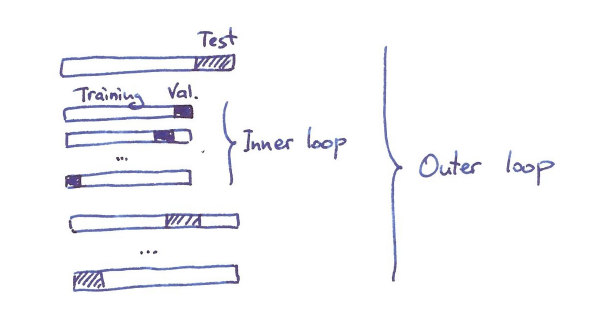

In [65]:
#tiempo_inicial = time.time()
lista_aseguradoras = datos_CV["GRCODE"].unique()
lista_aseguradoras
mejore_modelos_test_full = {}

for i in range(len(lista_aseguradoras)):
    print("aseguradora de test:", i)
    conj_test = lista_aseguradoras[i] #codigo de aseguradora de testeo
    datos_test = datos_CV[datos_CV["GRCODE"].isin([conj_test])] #datos de aseguradora de testeo
    conj_entre_valid = np.delete(lista_aseguradoras, i, axis=0) #Conjunto de validación y entrenamiento
    
    mejores_modelos = []
    
    for j in range(len(conj_entre_valid)):
        
        conj_vali = conj_entre_valid[j] #datos de aseguradora de validación
        conj_entre = np.delete(conj_entre_valid, j, axis=0) #aseguradoras de entrenamiento
        datos_train = datos_CV[datos_CV["GRCODE"].isin(conj_entre)] #datos de aseguradoras de entrenamiento
        datos_validacion = datos_CV[datos_CV["GRCODE"].isin([conj_vali])] #datos de aseguradora de validación

        #Se crea la clase que calculará las regresiones
        model1 = Reserva_Regresion_lineal(tabla = datos_train, origin = "AccidentYear", development = "DevelopmentLag", columns = datos_train.columns[5],
                                        index = "GRCODE", alpha = 0.001, matriz_de_ceros = matriz_de_ceros)
        
        #entrenamiento con conjunto de entrenamiento
        model1_regresion = model1.Regresion_lineal()

        #Se aplica la clase a los datos de validación
        model1_prediccion = model1.predict(datos_validacion) #acá el conjunto de validación escoge el mejor modelo de los tres de la clase
        
        #se aplica la clase a los datos de test
        #Acá se tienen las métricas evaluadas en el conjunto de teste del mejor modelo que el conjunto de validación escogió
        modelo_test = model1.predict_test(datos_test)

        mejore_modelos_test_full["modelo_"+str(i)+"-"+str(j)] = modelo_test

modelo_final = {}
for i in mejore_modelos_test_full.keys():
    modelo_final[i] = mejore_modelos_test_full[i]['Metricas MAPE']['MAPE modelo final']
    
nombre_modelo_final = list(dict(sorted(modelo_final.items(), key=lambda item: item[1])).keys())[0]
Mejor_modelo_reserva = mejore_modelos_test_full[nombre_modelo_final]

aseguradora de test: 0


aseguradora de test: 1
aseguradora de test: 2
aseguradora de test: 3
aseguradora de test: 4
aseguradora de test: 5
aseguradora de test: 6
aseguradora de test: 7
aseguradora de test: 8
aseguradora de test: 9
aseguradora de test: 10
aseguradora de test: 11
aseguradora de test: 12
aseguradora de test: 13
aseguradora de test: 14


#### El Mejor modelo

In [66]:
Mejor_modelo_reserva["nombre mejor modelo"]

'Regresión de Ridge'

#### Coeficientes del mejor modelo

In [67]:
Mejor_modelo_reserva["coeficientes"]

array([ 0.        ,  0.02791292,  0.01728219,  0.00486176, -0.01410948,
       -0.0270063 , -0.02865714, -0.02675069, -0.02558651, -0.02346842,
       -0.01723067,  0.13499618,  0.15901684,  0.14648954,  0.11313231,
        0.14768033,  0.14773552,  0.16175628, -0.06189354])

#### Comparación del mejor modelo
Comparación de los datos ajustados del mejor modelo con los datos de test

In [68]:
Mejor_modelo_reserva["Comparacion"]

,Y_test,Y_ajustado modelo final,GRCODE
0,8.756368,8.691381,1066
1,8.812248,8.904400,1066
2,8.453188,8.680751,1066
3,8.905580,8.877959,1066
4,8.828055,8.891980,1066
5,8.386857,8.668330,1066
6,8.947286,8.858933,1066
7,8.868835,8.858988,1066
8,8.782016,8.873009,1066
9,8.267192,8.649359,1066


#### Mejor modelo para modelar en caso de necesitarse

In [69]:
Mejor_modelo_reserva["mejor modelo"]

Ridge(alpha=0.001)

#### Métrica MAPE del mejor modelo con el conjunto de test
Esta métrica se compara con la del Chain-Ladder

In [70]:
Mejor_modelo_reserva["Metricas MAPE"]

{'MAPE modelo final': 1.3990479375611622}

#### Cálculo del MAPE para el método Chain-Ladder

In [71]:
MAPE1 = []
for i in datos_CV["GRCODE"].unique():
    diferencia = abs((triangulos_resultados[i]["Triangulo_full_acumulado"]-triangulos_resultados[i]["Triangulo_estimado"])
                     /triangulos_resultados[i]["Triangulo_full_acumulado"])
    MAPE = diferencia.sum().sum()/45*100
    MAPE1.append(MAPE)
MAPE1 = np.array(MAPE1)
Mape_chain_ladder = MAPE1.mean()
print("Métrica MAPE con el método Chain-Ladder:",Mape_chain_ladder)

Métrica MAPE con el método Chain-Ladder: 5.834171478270679


## Comparación de modelos

In [72]:
print("Métrica MAPE con el método Chain-Ladder:",Mape_chain_ladder)
print("Métrica MAPE con el modelo final:",Mejor_modelo_reserva["Metricas MAPE"]['MAPE modelo final'])

Métrica MAPE con el método Chain-Ladder: 5.834171478270679
Métrica MAPE con el modelo final: 1.3990479375611622


Como se evidencia anteriormente el modelo final tuvo un mejor rendimiento que el método tradicional por medio de la métrica MAPE, sin embargo esto puede ocurrir debido a la pequeña cantidad de aseguradoras que se toman, puede darse el caso de que si se trabaja con todas las aseguradoras el método tradicional puede ser mucho mejor.

Por último se responden las siguientes preguntas:

- ¿Conclusiones significativas del modelos final?

El modelo final de Lasso tuvo un mejor comportamiento que el método tradicional, sin embargo esto puede deberse a que no se trabaja con toda las aseguradoras del la base de datos, puesto que en anteriores estudios de los modelos cuando se aumenta la cantidad de aseguradoras al momento de entrenar los modelos estos pierden la posibilidad de caracterizar el comportamiento individual de cada aseguradora.

- ¿Donde hubo problemas para la ejecución de los modelos?

La clase que calcula el Chain-Ladder es la parte que más demora en ejecutarse y como el algoritmo de los modelos de regresión dependen de esta clase y el cross-validation depende del algoritmo de los modelos de regresión esta en la razón de porque el cross-validation se demora mucho en ejecutar.

- ¿Qué tan razonable fue el tiempo de procesamiento?

Se debe mejorar el entrenamiento de los modelos

- ¿El modelo tuvo problemas de calidad de datos, como datos faltantes?

No, los datos fueron de calidad

- ¿Hubo alguna inconsistencia en los cálculos?

No, los resultados son consistentes
